# 1. Import Library

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.random import set_seed
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.regularizers import l1, l2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import cv2 as cv
import time
from PIL import Image
import io

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

set_seed(0)
np.random.seed(0)

# 2. Data Preprocessing


In [11]:
path = "C:/Users/javie/Documents/Kuliah/Semester 6/Bangkit/Capstone/Dataset"

In [12]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(
        rescale = 1./255
)
test_datagen = ImageDataGenerator(
        rescale = 1./255
)

In [13]:
img_shape = (224, 224, 3) # default values

train_batch_size = 256
val_batch_size = 32

train_generator = train_datagen.flow_from_directory(
            path + '/train',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = train_batch_size,
            class_mode = 'categorical',)

validation_generator = validation_datagen.flow_from_directory(
            path + '/val',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False)

test_generator = test_datagen.flow_from_directory(
            path + '/test',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False,)

Found 1208 images belonging to 20 classes.
Found 738 images belonging to 20 classes.
Found 652 images belonging to 20 classes.


In [14]:
class_indices = train_generator.class_indices
classes = list(class_indices.keys())
print(classes)

['Botol Minum', 'Botol Minyak', 'Botol Obat', 'Botol Plastik', 'Botol Susu Bayi', 'Botol Susu dan Jus', 'Botol yang bisa ditekan', 'CD', 'Galon', 'Kemasan Detergen', 'Kemasan Makanan Beku', 'Kemasan Mentega', 'Makanan Ringan', 'Pipa', 'Plastik', 'Plastik Kiloan', 'Sedotan', 'Shampoo', 'Styrofoam', 'Wadah Makanan Plastik']


# 3. Arsitektur Model

Menggunakan VGG16

In [6]:
vgg = VGG16(weights = 'imagenet',
              include_top = False,
              input_shape = img_shape)

In [7]:
for layer in vgg.layers[:-3]:
    layer.trainable = False

In [8]:
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(classes), activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 20)                20500     
                                                                 
Total params: 40426324 (154.21 MB)
Trainable params: 30431252 (116.09 MB)
Non-trainable params: 9995072 (38.13 MB)
_________________________________________________________________


# 4. Training

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [11]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10
)

# Menyesuaikan ModelCheckpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    'PlasticWise.h5', 
    monitor='val_accuracy',  
    mode='max',
    verbose=1,
    save_best_only=True
)

# Melatih model dengan menggunakan callback yang telah disesuaikan
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[es, mc]  
)

Epoch 1/30




C:\Users\javie\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5/5 [==============================] - ETA: 0s - loss: 2.9794 - accuracy: 0.1225 
Epoch 1: val_accuracy improved from -inf to 0.40515, saving model to PlasticWise.h5


C:\Users\javie\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 127s 25s/step - loss: 2.9794 - accuracy: 0.1225 - val_loss: 2.2639 - val_accuracy: 0.4051
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 2.0878 - accuracy: 0.4106 
Epoch 2: val_accuracy improved from 0.40515 to 0.55556, saving model to PlasticWise.h5
5/5 [==============================] - 127s 26s/step - loss: 2.0878 - accuracy: 0.4106 - val_loss: 1.4668 - val_accuracy: 0.5556
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 1.4367 - accuracy: 0.5604 
Epoch 3: val_accuracy improved from 0.55556 to 0.64770, saving model to PlasticWise.h5
5/5 [==============================] - 125s 26s/step - loss: 1.4367 - accuracy: 0.5604 - val_loss: 1.1637 - val_accuracy: 0.6477
Epoch 4/30
5/5 [==============================] - ETA: 0s - loss: 1.1762 - accuracy: 0.6490 
Epoch 4: val_accuracy improved from 0.64770 to 0.71680, saving model to PlasticWise.h5
5/5 [==============================] - 126s 26s/step - loss: 1.1762 - acc

5/5 [==============================] - 123s 25s/step - loss: 0.1028 - accuracy: 0.9710 - val_loss: 0.5037 - val_accuracy: 0.8753
Epoch 30/30
5/5 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9669 
Epoch 30: val_accuracy did not improve from 0.87534
5/5 [==============================] - 121s 26s/step - loss: 0.1027 - accuracy: 0.9669 - val_loss: 0.5759 - val_accuracy: 0.8523


In [12]:
model.save('PlasticWise.h5')

# 5. Evaluasi Model

14/24 [================>.............] - ETA: 17s

C:\Users\javie\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


24/24 [==============================] - 41s 2s/step
                         precision    recall  f1-score   support

            Botol Minum       0.95      0.77      0.85        26
           Botol Minyak       0.78      0.95      0.86        57
             Botol Obat       0.94      0.85      0.89        20
          Botol Plastik       0.94      0.62      0.75        55
        Botol Susu Bayi       0.69      0.58      0.63        19
     Botol Susu dan Jus       0.73      0.94      0.82        32
Botol yang bisa ditekan       0.87      0.82      0.84        33
                     CD       0.90      0.95      0.92        19
                  Galon       0.76      0.93      0.84        45
       Kemasan Detergen       0.81      0.84      0.82        56
   Kemasan Makanan Beku       0.86      0.89      0.88        28
        Kemasan Mentega       0.89      0.89      0.89        27
         Makanan Ringan       0.94      0.94      0.94        34
                   Pipa       0.98  

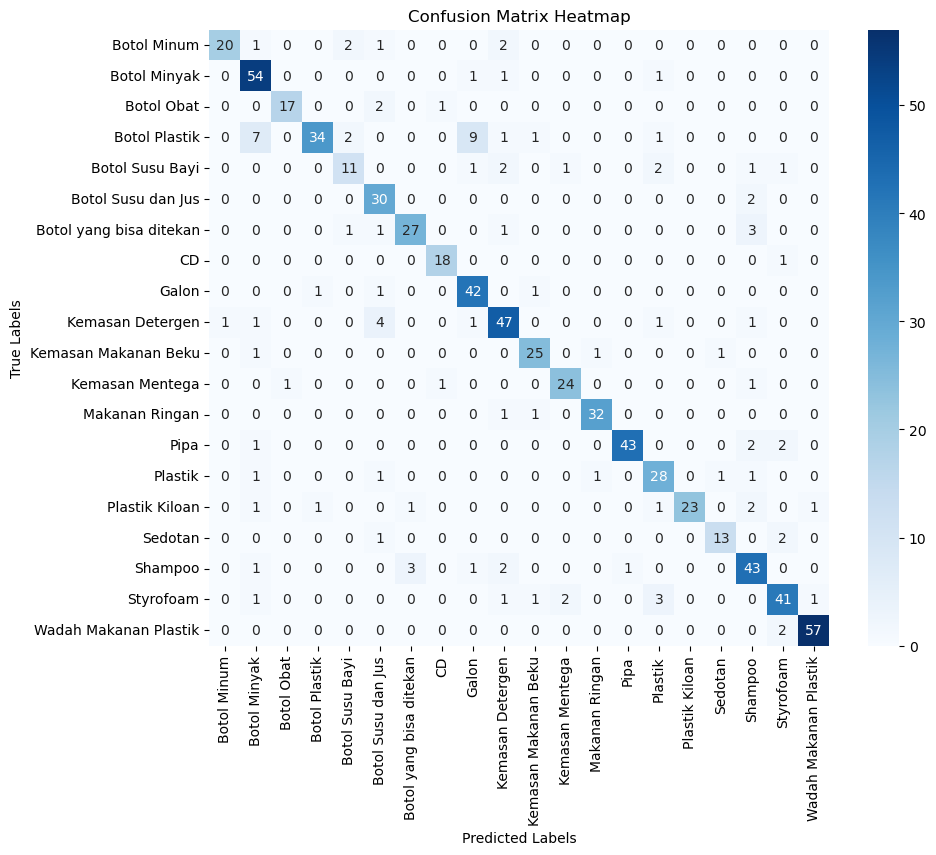

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Prediksi kelas dari data validasi
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = validation_generator.classes

# Classification Report
print(classification_report(true_classes, y_pred_classes, target_names=classes))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# 6. Pengujian

In [7]:
model = load_model('PlasticWise.h5')
num_test_samples = len(test_generator.filenames)

test_scores = model.evaluate_generator(test_generator, steps=num_test_samples // val_batch_size)

print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])

C:\Users\javie\AppData\Local\Temp\ipykernel_12596\2824390436.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_scores = model.evaluate_generator(test_generator, steps=num_test_samples // val_batch_size)



Test Loss: 0.6721571087837219
Test Accuracy: 0.84375


In [19]:
classes = ['Botol Minum', 'Botol Minyak', 'Botol Obat', 'Botol Plastik', 'Botol Susu Bayi', 
           'Botol Susu dan Jus', 'Botol yang bisa ditekan', 'CD', 'Galon', 'Kemasan Detergen', 
           'Kemasan Makanan Beku', 'Kemasan Mentega', 'Makanan Ringan', 'Pipa', 'Plastik', 
           'Plastik Kiloan', 'Sedotan', 'Shampoo', 'Styrofoam', 'Wadah Makanan Plastik']

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224)) 
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def classify_image(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_class = classes[np.argmax(prediction)]
    print("Predicted class:", predicted_class)


image_path = 'C:/Users/javie/Documents/Kuliah/Semester 6/Bangkit/Capstone/Dataset/test/Botol Minyak/myk12.png'  # ganti dengan path gambar yang ingin diuji
classify_image(image_path)

1/1 [==============================] - 0s 262ms/step
Predicted class: Botol Minyak


# 7. Deployment

In [9]:
!pip install tensorflow


In [ ]:
import tensorflowjs as tfjs

from keras.models import load_model

model = load_model("/content/drive/MyDrive/PlasticWise.h5")
tfjs.converters.save_keras_model(model,"/content/drive/MyDrive")